In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import matplotlib.cm as cm
from matplotlib import rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## Read The Data Locally 

In [ ]:
datanew = pd.read_csv("AIM_Task.csv",usecols=["Comments","dialect"])
datanew.head()

In [ ]:
datanew.shape         # the shape of the datafreame 

## 2) Clean the data [ Records] ( Check for :  
 A- Type of the Columns ,
 
 B- Count the Unique Values in the Dialect Column ,
 
 C- Duplicated records ,
 
 D- Null values 
 
 E - Remove the Signs

In [ ]:
datanew.info()   # check for the types of columns 

In [ ]:
datanew["dialect"].value_counts().count()   ## the number of the Classes in the dialect column

In [ ]:
datanew.duplicated().sum()  ## check for  duplicated records

In [ ]:
datanew.isnull().sum()## check for nan Values

In [ ]:
 ## The Data is already clean 

In [ ]:
sns.histplot(datanew["dialect"]) # Visualize the Dialect 
## As we see TN , YE have low value counts 

## 3 ) Clean The Comments :
A- Clean the data from the addidtives 

b- Clean and Normalize the Comments 

c- Shuffle the data 

## A- Clean the data from the addidtives 

In [ ]:
## A- Clean the Data from the addidtives by using Re  ( Remove the signs)
import re
lis=[]
for i in range(0,458):
    y= datanew["Comments"][i*1000:(i+1)*1000]
    for x in y:
        text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', '',x)
        lis.append(text)
print(lis)

## B- Clean and Normalize the Comments 

In [ ]:
# adapted from https://github.com/bakrianoo/aravec
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [ ]:
liss=[]
for i in lis : 
    liss.append(clean_text(i))

In [ ]:
lastdata=pd.DataFrame({"Comments":liss,
                      "Dialect":datanew["dialect"][0:458000].values})
lastdata.head()

## 3- Shuffle the Data 

In [ ]:
from sklearn.utils import shuffle
lastdata = shuffle(lastdata,random_state=42)
lastdata.head()

In [ ]:
lastdata.to_csv("ForDeepLearning.csv")       ## Save the model after cleaning 

## 4 ) Preprocess the Data :
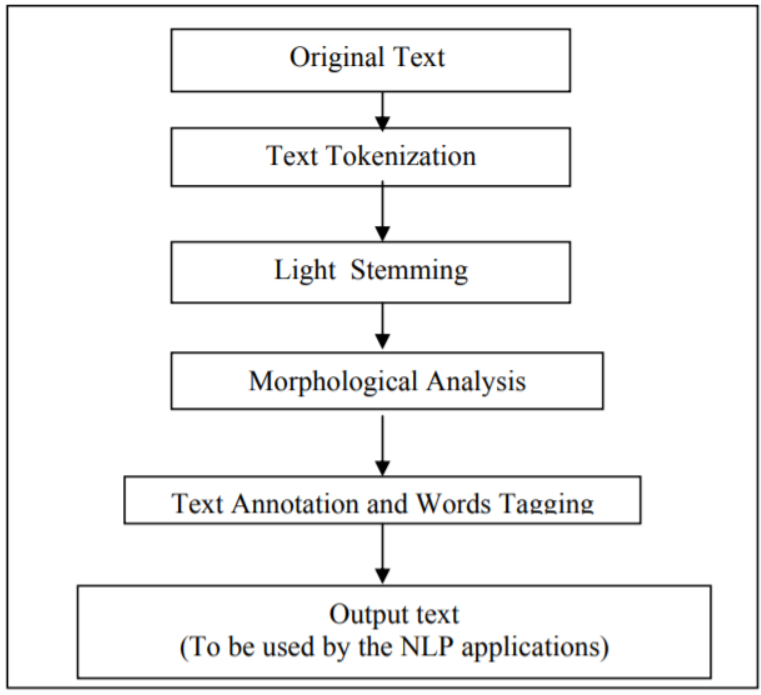

## A- Text Tokenize 


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')            ## import RegexpTokenizer from nltk
lastdata["Comments"] = lastdata["Comments"].apply(tokenizer.tokenize)


In [ ]:
lastdata["Comments"][:3]         ## Check for the texts after tokenization 

## B- Stop words

In [ ]:
stopwords_list = stopwords.words('arabic')     ## import stopwowrds from nltk.corpus

In [ ]:
stopwords_list[:10]     # check for sample of the stopwords 

In [ ]:
## Removing Stop Words  from the Comments :
lastdata["Comments"]= lastdata["Comments"].apply(lambda x: [item for item in x if item not in stopwords_list])

## C- Text Information : 

In [ ]:
all_words = [word for tokens in lastdata["Comments"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in lastdata["Comments"]]
VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

##  D- Top 25 words :

In [ ]:
counter = Counter(all_words)
counter.most_common(25)

In [ ]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)



## 5- Split The Data :

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(lastdata["Comments"],lastdata["Dialect"], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

## 6 - TF-IDF Vectorizer :

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True)

In [ ]:
vectorizer.fit(X_train.astype("U"))          # Fit the X Xtrain Only 

In [ ]:
Xtrain = vectorizer.transform(X_train.astype("U"))    # Transfor the Xtrain-Xval-Xtext
Xval = vectorizer.transform(X_valid.astype("U"))
Xtest = vectorizer.transform(X_test.astype("U"))

In [ ]:
## Save the Vectorizer Model : 
filename = 'TFIDF2.pkl'
pickle.dump(vectorizer, open(filename, 'wb'))